# Bollinger Bands Backtest with Tick Data

This notebook implements a high-performance Bollinger Bands trading strategy using tick-level data for realistic execution simulation.

## Strategy Overview
- **Entry Signal**: Long when close < lower band, Short when close > upper band
- **Exit Signal**: Close position when price reaches middle band
- **Position Limit**: Maximum 1 position at a time
- **Execution**: Realistic tick-level execution with bid/ask spread

## Data Processing
1. Load tick data (bid/ask prices with timestamps)
2. Resample to 1-minute OHLC for indicator calculation
3. Calculate Bollinger Bands on 1-minute data
4. Map signals back to tick data for execution
5. Execute strategy with numba optimization

## 📋 Configuration Parameters

Modify these parameters to easily test different configurations without changing code throughout the notebook.

In [11]:
# ========================================
# 📋 GLOBAL CONFIGURATION PARAMETERS
# ========================================

# 📁 Data Configuration
TICK_DATA_PATH = '/home/edocame/Desktop/data_python/tick_lastmonth.csv'

# 📊 Bollinger Bands Strategy Parameters
BB_WINDOW = 1000        # Period for Bollinger Bands calculation (minutes) - Default: 1440 (24h)
BB_STD = 2           # Number of standard deviations for bands - Default: 1.0
BB_PRICE_COL = 'close' # Price column to use for BB calculation

# 🎯 Trading Strategy Parameters
MAX_POSITION_SIZE = 1   # Maximum number of concurrent positions
INITIAL_CAPITAL = 10000 # Starting capital for performance metrics

# 📈 Performance Analysis Parameters
PLOT_FIGURES_SIZE = (15, 10)           # Default figure size for plots
REGRESSION_FIGURES_SIZE = (16, 12)     # Figure size for regression analysis

# 🔧 Technical Parameters
RANDOM_SEED = 42        # For reproducible results
WARNING_SUPPRESS = True # Suppress pandas/numpy warnings

print("✅ Configuration parameters loaded:")
print(f"📁 Tick Data Path: {TICK_DATA_PATH}")
print(f"📊 BB Window: {BB_WINDOW} periods")
print(f"📊 BB Standard Deviation: {BB_STD}")
print(f"💰 Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"🎯 Max Position Size: {MAX_POSITION_SIZE}")
print("=" * 50)

✅ Configuration parameters loaded:
📁 Tick Data Path: /home/edocame/Desktop/data_python/tick_lastmonth.csv
📊 BB Window: 1000 periods
📊 BB Standard Deviation: 2
💰 Initial Capital: $10,000
🎯 Max Position Size: 1


In [12]:
import backtrader as bt
import pandas as pd
import numpy as np
import numba as nb
from numba import jit
import warnings
import time

# Apply configuration settings
if WARNING_SUPPRESS:
    warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")
print(f"📁 Using data path: {TICK_DATA_PATH}")
print(f"⚙️ Random seed set to: {RANDOM_SEED}")

✅ Libraries imported successfully
📁 Using data path: /home/edocame/Desktop/data_python/tick_lastmonth.csv
⚙️ Random seed set to: 42


## 2. Core Functions

In [13]:
def calculate_bollinger_bands(df, price_col=BB_PRICE_COL, window=BB_WINDOW, num_std=BB_STD):
    """Calculate Bollinger Bands using global configuration parameters"""
    df['middle_band'] = df[price_col].rolling(window).mean()
    std = df[price_col].rolling(window).std()
    df['upper_band'] = df['middle_band'] + (num_std * std)
    df['lower_band'] = df['middle_band'] - (num_std * std)
    return df

In [14]:
@jit(nopython=True)
def bollinger_strategy_numeric(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands):
    """Numba-optimized Bollinger Bands strategy"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    
    for i in range(1, n):
        current_close = close_prices[i-1]
        current_upper = upper_bands[i-1]
        current_middle = middle_bands[i-1]
        current_lower = lower_bands[i-1]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                exit_price = current_bid if position == 1 else current_ask
                pnl = (exit_price - entry_price) if position == 1 else (entry_price - exit_price)
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    trade_count += 1
                
                position = 0
        
        # Open new position
        if position == 0:
            if current_close < current_lower:
                position = 1
                entry_price = current_ask
                entry_idx = i
            elif current_close > current_upper:
                position = -1
                entry_price = current_bid
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count])

def run_fast_bollinger_backtest(tick_data_path=TICK_DATA_PATH, bb_window=BB_WINDOW, bb_std=BB_STD):
    """Ultra-fast Bollinger Bands backtest using global configuration"""
    # Load and process data
    df_ticks = pd.read_csv(tick_data_path)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Execute strategy
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnls = bollinger_strategy_numeric(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values
    )
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl': pnls
        })
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        return trades_df, df_1min
    
    return None, df_1min

In [15]:
@jit(nopython=True)
def bollinger_strategy_full_equity(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands, initial_capital):
    """Numba-optimized Bollinger Bands strategy with full equity position sizing"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    position_sizes = np.zeros(max_trades, dtype=np.float64)
    equities = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    current_equity = initial_capital
    position_size = 0.0
    
    for i in range(1, n):
        current_close = close_prices[i-1]
        current_upper = upper_bands[i-1]
        current_middle = middle_bands[i-1]
        current_lower = lower_bands[i-1]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                exit_price = current_bid if position == 1 else current_ask
                
                # Calculate PnL based on position size
                if position == 1:  # Long position
                    pnl = (exit_price - entry_price)  * position_size
                else:  # Short position
                    pnl = (entry_price - exit_price) * position_size
                
                # Update equity
                current_equity += pnl  
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    position_sizes[trade_count] = position_size
                    equities[trade_count] = current_equity
                    trade_count += 1
                
                position = 0
                position_size = 0.0
        
        # Open new position using 100% of available equity
        if position == 0 and current_equity > 0:
            if current_close < current_lower:
                position = 1
                entry_price = current_ask
                position_size = current_equity / current_ask  # Use all equity
                entry_idx = i
            elif current_close > current_upper:
                position = -1
                entry_price = current_bid
                position_size = current_equity / current_bid  # Use all equity equivalent
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count],
            position_sizes[:trade_count], equities[:trade_count])

In [16]:
def run_full_equity_bollinger_backtest(tick_data_path=TICK_DATA_PATH, bb_window=BB_WINDOW, bb_std=BB_STD, initial_capital=INITIAL_CAPITAL):
    """Ultra-fast Bollinger Bands backtest with full equity position sizing"""
    # Load and process data
    df_ticks = pd.read_csv(tick_data_path)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Execute strategy with full equity
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnls, position_sizes, equities = bollinger_strategy_full_equity(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values,
        initial_capital
    )
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl': pnls,
            'position_size': position_sizes,
            'equity_after_trade': equities
        })
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['return_pct'] = trades_df['pnl'] / (trades_df['equity_after_trade'] - trades_df['pnl']) * 100
        return trades_df, df_1min
    
    return None, df_1min

## 3. Ultra-Fast Backtest Implementation

This section contains the optimized numba-accelerated trading strategy and backtesting engine.

In [17]:
# Execute backtest using global configuration with full equity positioning
start_time = time.time()
trades_df_fast, df_1min_fast = run_full_equity_bollinger_backtest()
execution_time = time.time() - start_time

# Show results
if trades_df_fast is not None:
    print(f"🚀 Backtest completed in {execution_time:.2f}s")
    print(f"📊 Strategy Configuration:")
    print(f"   📊 BB Window: {BB_WINDOW} periods")
    print(f"   📊 BB Std Dev: {BB_STD}")
    print(f"   📁 Data: {TICK_DATA_PATH.split('/')[-1]}")
    print(f"   💰 Initial Capital: ${INITIAL_CAPITAL:,}")
    print("=" * 50)
    print(f"📊 Trades: {len(trades_df_fast)}")
    print(f"💰 Total PnL: ${trades_df_fast['pnl'].sum():.2f}")
    print(f"📈 Total Return: {((trades_df_fast['equity_after_trade'].iloc[-1] / INITIAL_CAPITAL) - 1) * 100:.2f}%")
    print(f"📈 Win Rate: {(trades_df_fast['pnl'] > 0).mean():.1%}")
    print(f"⏱️ Avg Duration: {trades_df_fast['duration'].mean()}")
    print(f"📊 Final Equity: ${trades_df_fast['equity_after_trade'].iloc[-1]:,.2f}")
    print(f"📊 Avg Return per Trade: {trades_df_fast['return_pct'].mean():.3f}%")
else:
    print("❌ No trades executed")

🚀 Backtest completed in 5.38s
📊 Strategy Configuration:
   📊 BB Window: 1000 periods
   📊 BB Std Dev: 2
   📁 Data: tick_lastmonth.csv
   💰 Initial Capital: $10,000
📊 Trades: 137
💰 Total PnL: $-553.88
📈 Total Return: -5.54%
📈 Win Rate: 62.0%
⏱️ Avg Duration: 0 days 10:02:54.175182481
📊 Final Equity: $9,446.12
📊 Avg Return per Trade: -0.041%


## 5. Performance Visualization

Let's create an equity curve and other performance visualizations to better understand the strategy behavior.

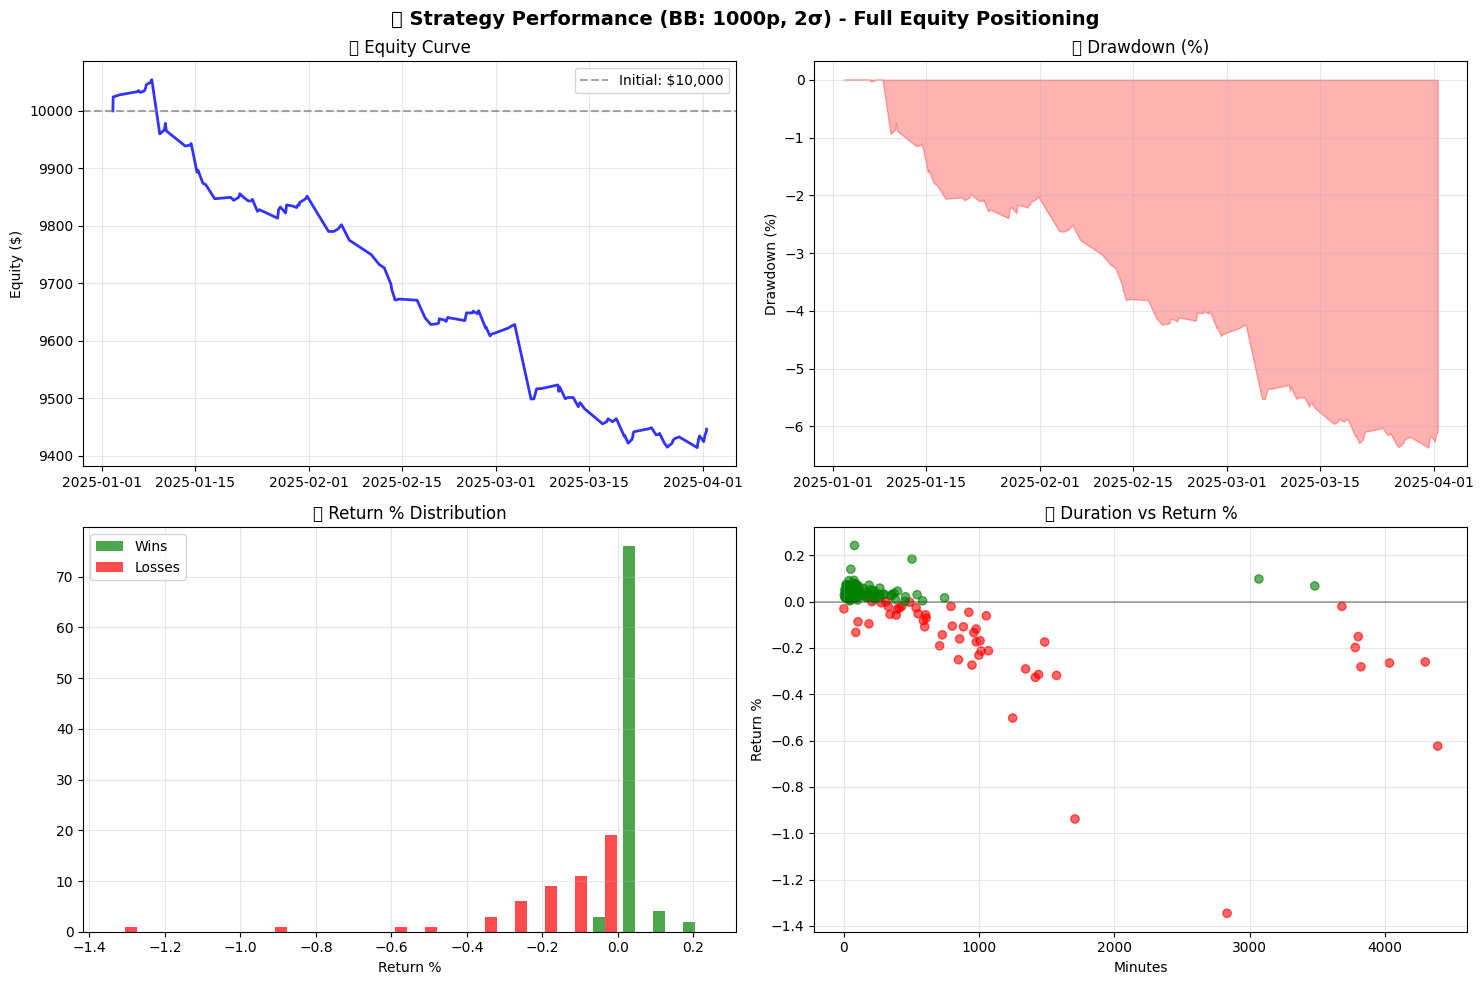

📈 Total Return: -5.54%
📉 Max Drawdown: -6.37%
🎯 Win Rate: 62.0%
📊 Avg Return per Trade: -0.041%
💰 Final Equity: $9,446.12
📊 Sharpe (return %): -0.224


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance(trades_df, initial_capital=INITIAL_CAPITAL):
    """Create performance dashboard using global configuration with proper equity curve"""
    if trades_df is None:
        print("❌ No trades to plot")
        return
    
    # Calculate proper equity curve using the equity_after_trade column
    trades_df = trades_df.copy()
    
    # Create equity curve that starts from initial capital
    equity_curve = [initial_capital]
    equity_curve.extend(trades_df['equity_after_trade'].tolist())
    
    # Create timestamps for equity curve
    time_curve = [trades_df['entry_time'].iloc[0]]
    time_curve.extend(trades_df['exit_time'].tolist())
    
    trades_df['equity'] = trades_df['equity_after_trade']
    trades_df['running_max'] = trades_df['equity'].expanding().max()
    trades_df['drawdown'] = (trades_df['equity'] - trades_df['running_max']) / trades_df['running_max'] * 100
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=PLOT_FIGURES_SIZE)
    fig.suptitle(f'🚀 Strategy Performance (BB: {BB_WINDOW}p, {BB_STD}σ) - Full Equity Positioning', fontsize=14, fontweight='bold')
    
    # Equity curve
    ax1.plot(time_curve, equity_curve, 'b-', alpha=0.8, linewidth=2)
    ax1.axhline(initial_capital, color='gray', linestyle='--', alpha=0.7, label=f'Initial: ${initial_capital:,}')
    ax1.set_title('💰 Equity Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel('Equity ($)')
    
    # Drawdown
    ax2.fill_between(trades_df['exit_time'], trades_df['drawdown'], 0, color='red', alpha=0.3)
    ax2.set_title('📉 Drawdown (%)')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylabel('Drawdown (%)')
    
    # Return percentage distribution
    wins = trades_df[trades_df['pnl'] > 0]['return_pct']
    losses = trades_df[trades_df['pnl'] <= 0]['return_pct']
    ax3.hist([wins, losses], bins=20, alpha=0.7, color=['green', 'red'], label=['Wins', 'Losses'])
    ax3.set_title('📊 Return % Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlabel('Return %')
    
    # Duration vs Return %
    durations = trades_df['duration'].dt.total_seconds() / 60
    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl']]
    ax4.scatter(durations, trades_df['return_pct'], c=colors, alpha=0.6)
    ax4.set_title('⏱️ Duration vs Return %')
    ax4.set_xlabel('Minutes')
    ax4.set_ylabel('Return %')
    ax4.axhline(0, color='black', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Metrics
    final_equity = equity_curve[-1]
    total_return = (final_equity - initial_capital) / initial_capital * 100
    max_dd = trades_df['drawdown'].min()
    win_rate = (trades_df['pnl'] > 0).mean()
    avg_return = trades_df['return_pct'].mean()
    
    print(f"📈 Total Return: {total_return:.2f}%")
    print(f"📉 Max Drawdown: {max_dd:.2f}%")
    print(f"🎯 Win Rate: {win_rate:.1%}")
    print(f"📊 Avg Return per Trade: {avg_return:.3f}%")
    print(f"💰 Final Equity: ${final_equity:,.2f}")
    print(f"📊 Sharpe (return %): {trades_df['return_pct'].mean()/trades_df['return_pct'].std():.3f}")

# Auto-plot if we have trades
if 'trades_df_fast' in locals() and trades_df_fast is not None:
    plot_performance(trades_df_fast)

## 6. Summary

### ✅ What We Built:
- **Ultra-fast backtesting engine** with tick-level execution
- **Realistic spread simulation** using bid/ask prices  
- **Numba optimization** for 5M+ tick processing in seconds
- **Comprehensive visualization** with equity curve and metrics

### 🎯 Next Steps:
1. Parameter optimization (test different BB periods/std)
2. Risk management (stop-loss, position sizing)
3. Market regime filtering
4. Transaction cost modeling

## 7. Duration vs PnL Regression Analysis

Let's perform a detailed statistical analysis of the relationship between trade duration and PnL to quantify the negative correlation observed in the scatter plot.

📊 Analysis Dataset: 137 trades
⏱️ Duration Range: 2.0 - 4389.2 minutes
💰 PnL Range: -129.588185 - 24.278554
------------------------------------------------------------
🔗 Pearson Correlation: -0.5674
📈 P-value: 4.88e-13
🎯 Significance: Significant (α=0.05)
🔄 Spearman Correlation: -0.6708 (p=3.03e-19)
------------------------------------------------------------
📈 LINEAR REGRESSION RESULTS:
   📐 Slope (β₁): -0.01057870 PnL per minute
   📍 Intercept (β₀): 2.334979
   📊 R²: 0.3219 (32.19% variance explained)
   🔍 Slope t-statistic: -8.064
   📈 Slope p-value: 3.52e-13
   🎯 Slope significance: Significant
------------------------------------------------------------
🧠 INTERPRETATION:
   📉 Strong negative correlation detected (-0.567)
   ⏰ PnL decreases by 0.01057870 per minute
   ⏰ PnL decreases by 0.634722 per hour
   💡 Longer trades tend to be less profitable


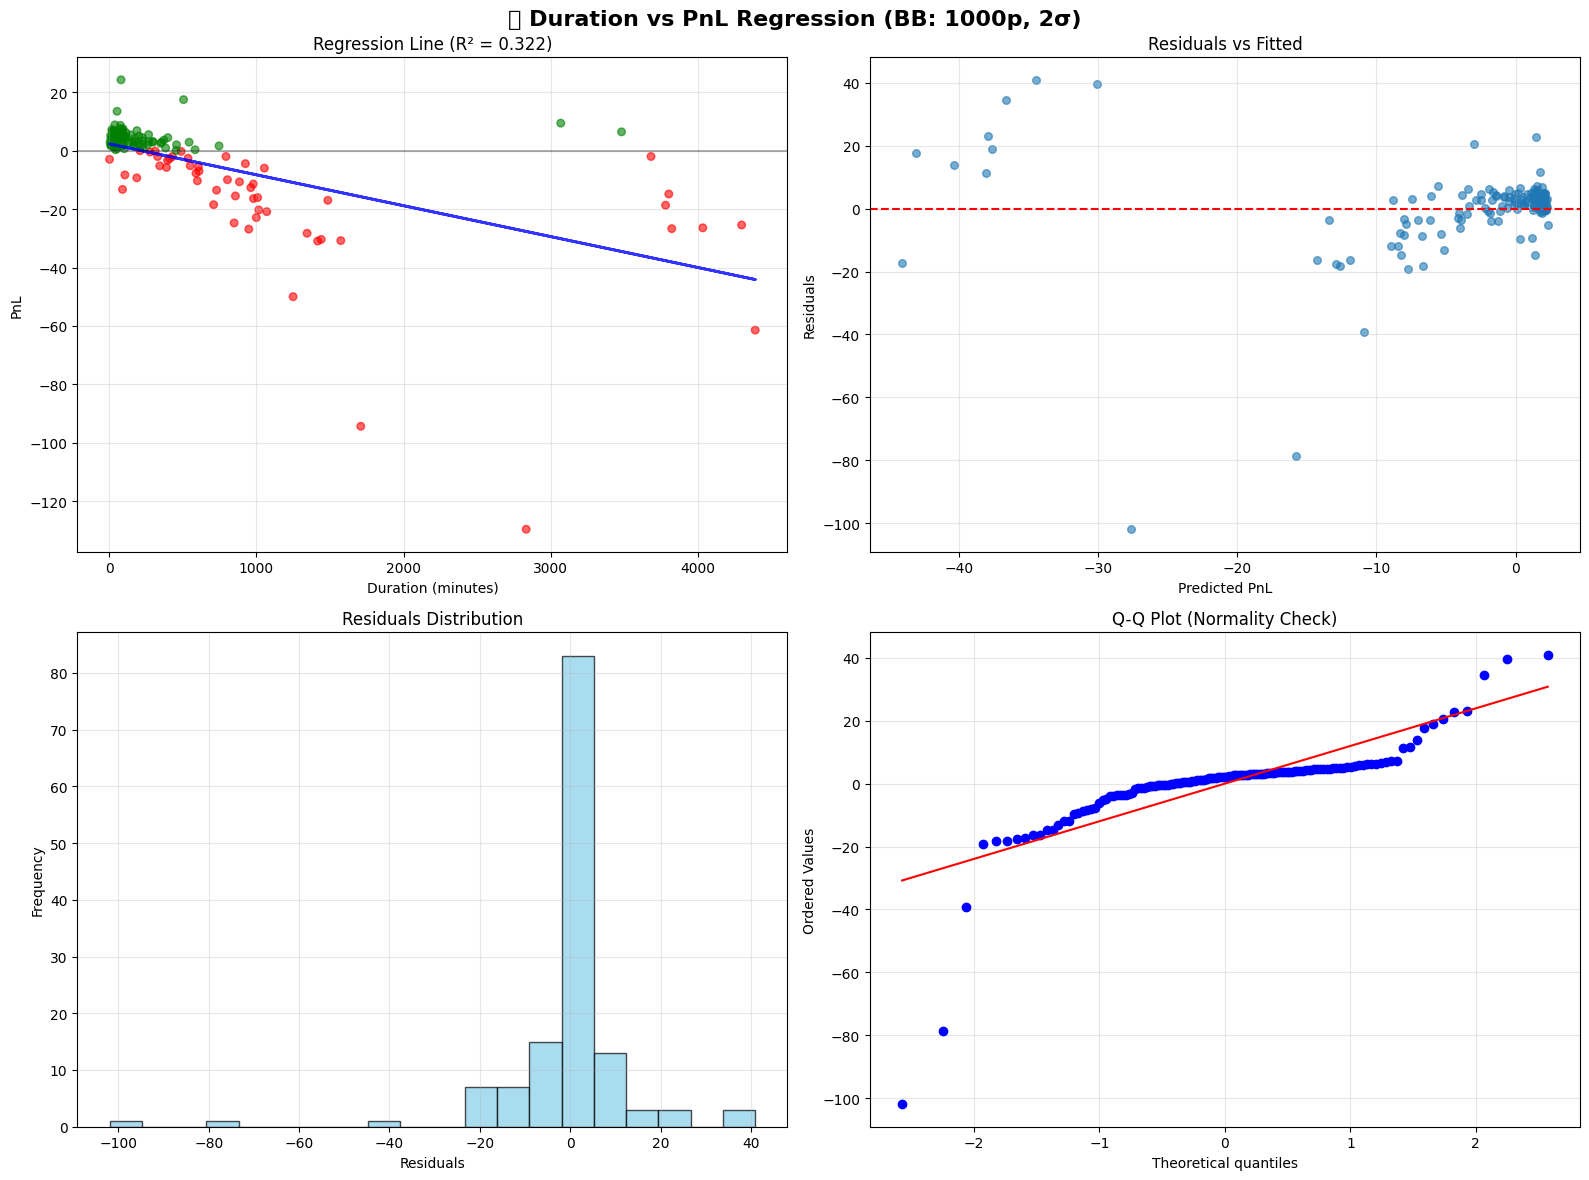


📊 ADDITIONAL STATISTICS:
   📏 Mean Duration: 602.9 minutes
   📏 Median Duration: 223.0 minutes
   💰 Mean PnL: -4.042949
   💰 Median PnL: 1.864072
   📊 PnL Std Dev: 18.035917


In [19]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def analyze_duration_pnl_relationship(trades_df):
    """Perform comprehensive regression analysis between duration and PnL"""
    if trades_df is None or len(trades_df) == 0:
        print("❌ No trades data available for analysis")
        return
    
    # Prepare data
    trades_analysis = trades_df.copy()
    trades_analysis['duration_minutes'] = trades_analysis['duration'].dt.total_seconds() / 60
    
    # Remove any potential outliers or invalid data
    valid_trades = trades_analysis.dropna(subset=['duration_minutes', 'pnl'])
    duration_data = valid_trades['duration_minutes'].values.reshape(-1, 1)
    pnl_data = valid_trades['pnl'].values
    
    print(f"📊 Analysis Dataset: {len(valid_trades)} trades")
    print(f"⏱️ Duration Range: {valid_trades['duration_minutes'].min():.1f} - {valid_trades['duration_minutes'].max():.1f} minutes")
    print(f"💰 PnL Range: {valid_trades['pnl'].min():.6f} - {valid_trades['pnl'].max():.6f}")
    print("-" * 60)
    
    # 1. Pearson Correlation Analysis
    correlation, p_value = stats.pearsonr(valid_trades['duration_minutes'], valid_trades['pnl'])
    print(f"🔗 Pearson Correlation: {correlation:.4f}")
    print(f"📈 P-value: {p_value:.2e}")
    print(f"🎯 Significance: {'Significant' if p_value < 0.05 else 'Not Significant'} (α=0.05)")
    
    # 2. Spearman Rank Correlation (non-parametric)
    spearman_corr, spearman_p = stats.spearmanr(valid_trades['duration_minutes'], valid_trades['pnl'])
    print(f"🔄 Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")
    print("-" * 60)
    
    # 3. Linear Regression Analysis
    reg_model = LinearRegression()
    reg_model.fit(duration_data, pnl_data)
    
    # Predictions and metrics
    pnl_predicted = reg_model.predict(duration_data)
    r2 = r2_score(pnl_data, pnl_predicted)
    
    # Statistical tests
    n = len(valid_trades)
    slope = reg_model.coef_[0]
    intercept = reg_model.intercept_
    
    # Calculate standard error and t-statistic for slope
    residuals = pnl_data - pnl_predicted
    mse = np.mean(residuals**2)
    se_slope = np.sqrt(mse / np.sum((valid_trades['duration_minutes'] - valid_trades['duration_minutes'].mean())**2))
    t_stat = slope / se_slope
    t_p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n-2))
    
    print("📈 LINEAR REGRESSION RESULTS:")
    print(f"   📐 Slope (β₁): {slope:.8f} PnL per minute")
    print(f"   📍 Intercept (β₀): {intercept:.6f}")
    print(f"   📊 R²: {r2:.4f} ({r2*100:.2f}% variance explained)")
    print(f"   🔍 Slope t-statistic: {t_stat:.3f}")
    print(f"   📈 Slope p-value: {t_p_value:.2e}")
    print(f"   🎯 Slope significance: {'Significant' if t_p_value < 0.05 else 'Not Significant'}")
    print("-" * 60)
    
    # 4. Interpretation
    print("🧠 INTERPRETATION:")
    if correlation < -0.3:
        print(f"   📉 Strong negative correlation detected ({correlation:.3f})")
    elif correlation < -0.1:
        print(f"   📉 Moderate negative correlation detected ({correlation:.3f})")
    else:
        print(f"   📊 Weak relationship detected ({correlation:.3f})")
    
    if slope < 0:
        pnl_loss_per_hour = slope * 60
        print(f"   ⏰ PnL decreases by {abs(slope):.8f} per minute")
        print(f"   ⏰ PnL decreases by {abs(pnl_loss_per_hour):.6f} per hour")
        print(f"   💡 Longer trades tend to be less profitable")
    else:
        print(f"   💡 Longer trades tend to be more profitable")
    
    # 5. Visual Analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=REGRESSION_FIGURES_SIZE)
    fig.suptitle(f'📊 Duration vs PnL Regression (BB: {BB_WINDOW}p, {BB_STD}σ)', fontsize=16, fontweight='bold')
    
    # Scatter plot with regression line
    ax1.scatter(valid_trades['duration_minutes'], valid_trades['pnl'], 
               alpha=0.6, c=['green' if p > 0 else 'red' for p in valid_trades['pnl']], s=30)
    ax1.plot(valid_trades['duration_minutes'], pnl_predicted, 'blue', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('PnL')
    ax1.set_title(f'Regression Line (R² = {r2:.3f})')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', alpha=0.3)
    
    # Residuals plot
    ax2.scatter(pnl_predicted, residuals, alpha=0.6, s=30)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Predicted PnL')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals vs Fitted')
    ax2.grid(True, alpha=0.3)
    
    # Distribution of residuals
    ax3.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Residuals Distribution')
    ax3.grid(True, alpha=0.3)
    
    # QQ plot for normality check
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Additional Statistics
    print("\n📊 ADDITIONAL STATISTICS:")
    print(f"   📏 Mean Duration: {valid_trades['duration_minutes'].mean():.1f} minutes")
    print(f"   📏 Median Duration: {valid_trades['duration_minutes'].median():.1f} minutes")
    print(f"   💰 Mean PnL: {valid_trades['pnl'].mean():.6f}")
    print(f"   💰 Median PnL: {valid_trades['pnl'].median():.6f}")
    print(f"   📊 PnL Std Dev: {valid_trades['pnl'].std():.6f}")
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'slope': slope,
        'intercept': intercept,
        'r2': r2,
        'n_trades': len(valid_trades)
    }

# Execute analysis if trades data exists
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    regression_results = analyze_duration_pnl_relationship(trades_df_fast)
else:
    print("❌ No trades data available. Please run the backtest first.")

🎯 Running filtered regression analysis...
📋 Filter Range: 0 - 1500 minutes
💡 Tip: Modify MIN_DURATION_MINUTES and MAX_DURATION_MINUTES above to change the range
🔍 FILTERED ANALYSIS (Duration: 0-1500 minutes)
📊 Original Dataset: 137 trades
📊 Filtered Dataset: 125 trades (91.2%)
⏱️ Duration Range: 2.0 - 1485.0 minutes
💰 PnL Range: -49.961990 - 24.278554
------------------------------------------------------------
🔗 Pearson Correlation: -0.8170 (p=3.44e-31)
🔄 Spearman Correlation: -0.6711 (p=1.10e-17)
🎯 Significance: Significant (α=0.05)
------------------------------------------------------------
📈 FILTERED REGRESSION RESULTS:
   📐 Slope (β₁): -0.02272358 PnL per minute
   📍 Intercept (β₀): 6.540747
   📊 R²: 0.6675 (66.75% variance explained)
   ⏰ PnL decreases by 0.02272358 per minute
   ⏰ PnL decreases by 1.363415 per hour
------------------------------------------------------------


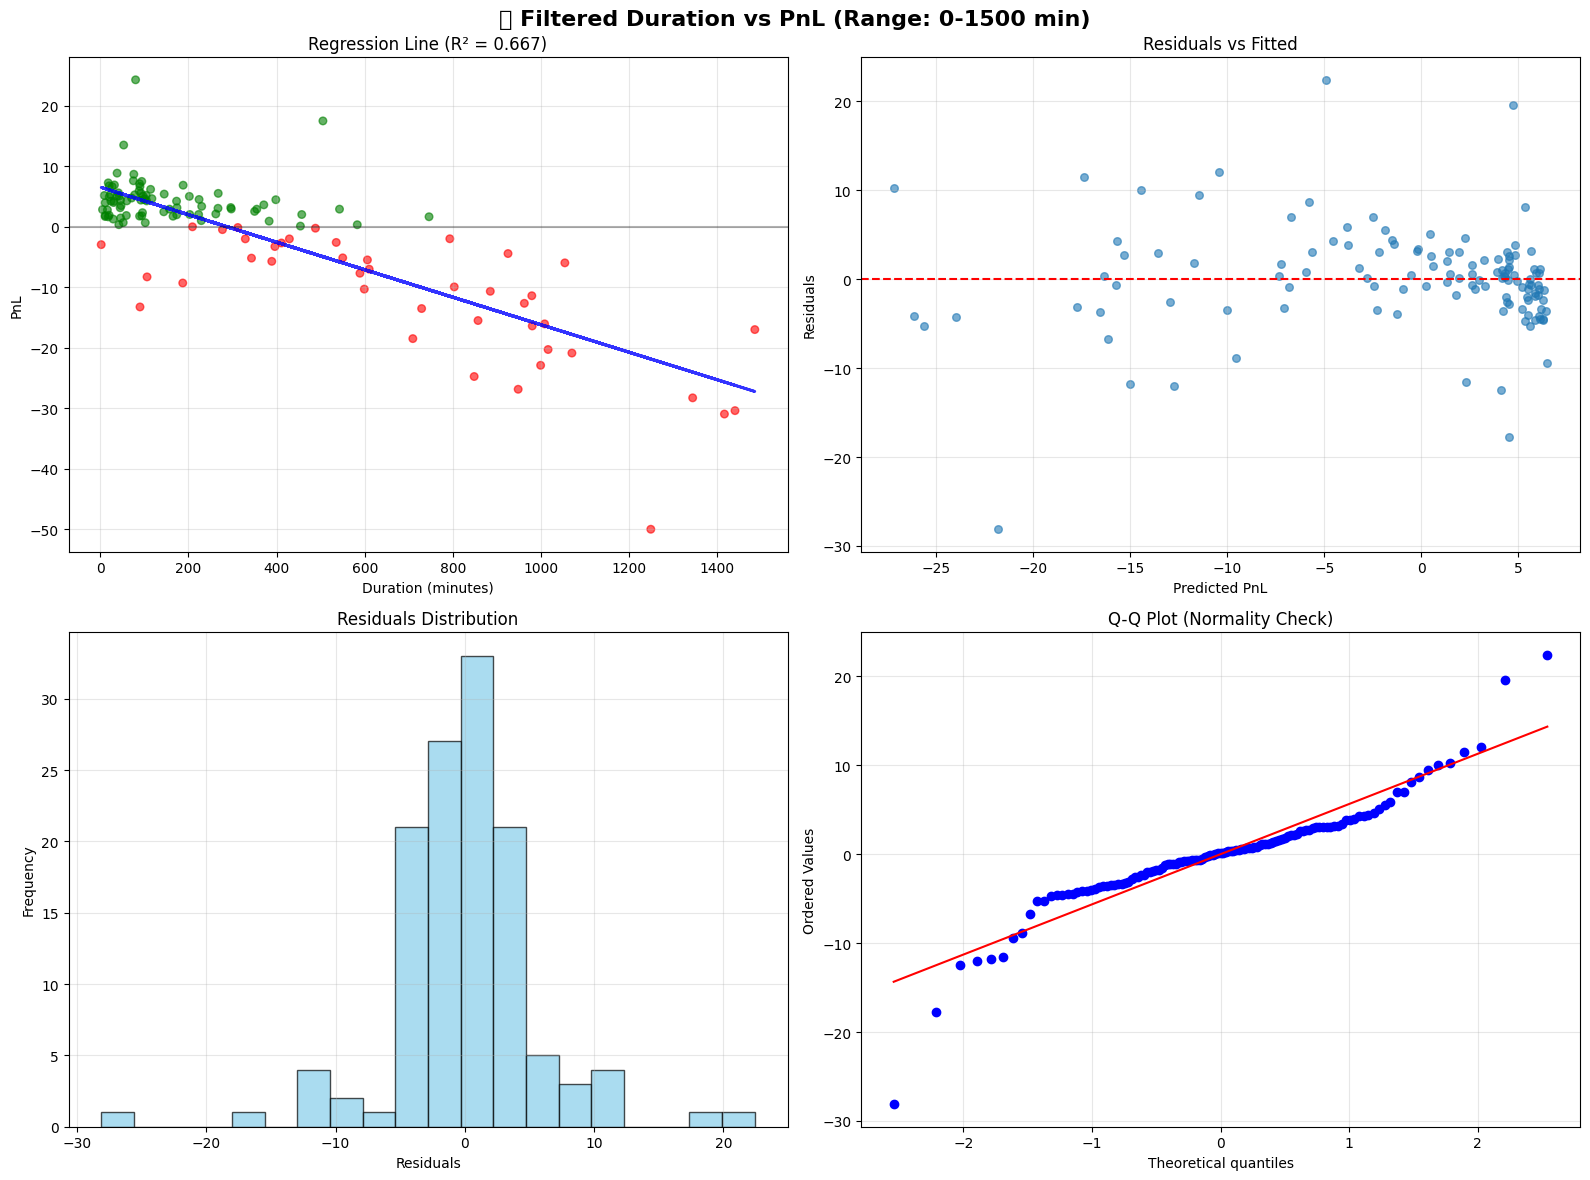

📊 FILTERED STATISTICS:
   📏 Mean Duration: 337.0 minutes
   📏 Median Duration: 173.9 minutes
   💰 Mean PnL: -1.117930
   💰 Median PnL: 2.032895
   📊 PnL Std Dev: 10.300052
   🎯 Win Rate: 66.4%


In [21]:
# ========================================
# 🎯 FILTERED REGRESSION ANALYSIS
# ========================================

# 📋 Configure your duration range here (in minutes)
MIN_DURATION_MINUTES = 0      # Minimum duration to include
MAX_DURATION_MINUTES = 1500   # Maximum duration to include (set to exclude outliers)

def analyze_duration_pnl_filtered(trades_df, min_duration=MIN_DURATION_MINUTES, max_duration=MAX_DURATION_MINUTES):
    """Perform regression analysis with custom duration filtering"""
    if trades_df is None or len(trades_df) == 0:
        print("❌ No trades data available for analysis")
        return
    
    # Prepare data
    trades_analysis = trades_df.copy()
    trades_analysis['duration_minutes'] = trades_analysis['duration'].dt.total_seconds() / 60
    
    # Apply duration filtering
    filtered_trades = trades_analysis[
        (trades_analysis['duration_minutes'] >= min_duration) & 
        (trades_analysis['duration_minutes'] <= max_duration)
    ].dropna(subset=['duration_minutes', 'pnl'])
    
    duration_data = filtered_trades['duration_minutes'].values.reshape(-1, 1)
    pnl_data = filtered_trades['pnl'].values
    
    print(f"🔍 FILTERED ANALYSIS (Duration: {min_duration}-{max_duration} minutes)")
    print(f"📊 Original Dataset: {len(trades_analysis)} trades")
    print(f"📊 Filtered Dataset: {len(filtered_trades)} trades ({len(filtered_trades)/len(trades_analysis)*100:.1f}%)")
    print(f"⏱️ Duration Range: {filtered_trades['duration_minutes'].min():.1f} - {filtered_trades['duration_minutes'].max():.1f} minutes")
    print(f"💰 PnL Range: {filtered_trades['pnl'].min():.6f} - {filtered_trades['pnl'].max():.6f}")
    print("-" * 60)
    
    # Correlation Analysis
    correlation, p_value = stats.pearsonr(filtered_trades['duration_minutes'], filtered_trades['pnl'])
    spearman_corr, spearman_p = stats.spearmanr(filtered_trades['duration_minutes'], filtered_trades['pnl'])
    
    print(f"🔗 Pearson Correlation: {correlation:.4f} (p={p_value:.2e})")
    print(f"🔄 Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")
    print(f"🎯 Significance: {'Significant' if p_value < 0.05 else 'Not Significant'} (α=0.05)")
    print("-" * 60)
    
    # Linear Regression
    reg_model = LinearRegression()
    reg_model.fit(duration_data, pnl_data)
    pnl_predicted = reg_model.predict(duration_data)
    r2 = r2_score(pnl_data, pnl_predicted)
    
    slope = reg_model.coef_[0]
    intercept = reg_model.intercept_
    residuals = pnl_data - pnl_predicted
    
    print("📈 FILTERED REGRESSION RESULTS:")
    print(f"   📐 Slope (β₁): {slope:.8f} PnL per minute")
    print(f"   📍 Intercept (β₀): {intercept:.6f}")
    print(f"   📊 R²: {r2:.4f} ({r2*100:.2f}% variance explained)")
    
    if slope < 0:
        pnl_loss_per_hour = slope * 60
        print(f"   ⏰ PnL decreases by {abs(slope):.8f} per minute")
        print(f"   ⏰ PnL decreases by {abs(pnl_loss_per_hour):.6f} per hour")
    print("-" * 60)
    
    # Visual Analysis - Same plots as original
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=REGRESSION_FIGURES_SIZE)
    fig.suptitle(f'📊 Filtered Duration vs PnL (Range: {min_duration}-{max_duration} min)', fontsize=16, fontweight='bold')
    
    # Scatter plot with regression line
    ax1.scatter(filtered_trades['duration_minutes'], filtered_trades['pnl'], 
               alpha=0.6, c=['green' if p > 0 else 'red' for p in filtered_trades['pnl']], s=30)
    ax1.plot(filtered_trades['duration_minutes'], pnl_predicted, 'blue', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('PnL')
    ax1.set_title(f'Regression Line (R² = {r2:.3f})')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', alpha=0.3)
    
    # Residuals plot
    ax2.scatter(pnl_predicted, residuals, alpha=0.6, s=30)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Predicted PnL')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals vs Fitted')
    ax2.grid(True, alpha=0.3)
    
    # Distribution of residuals
    ax3.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Residuals Distribution')
    ax3.grid(True, alpha=0.3)
    
    # QQ plot for normality check
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional Statistics
    print(f"📊 FILTERED STATISTICS:")
    print(f"   📏 Mean Duration: {filtered_trades['duration_minutes'].mean():.1f} minutes")
    print(f"   📏 Median Duration: {filtered_trades['duration_minutes'].median():.1f} minutes")
    print(f"   💰 Mean PnL: {filtered_trades['pnl'].mean():.6f}")
    print(f"   💰 Median PnL: {filtered_trades['pnl'].median():.6f}")
    print(f"   📊 PnL Std Dev: {filtered_trades['pnl'].std():.6f}")
    print(f"   🎯 Win Rate: {(filtered_trades['pnl'] > 0).mean():.1%}")
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'slope': slope,
        'intercept': intercept,
        'r2': r2,
        'n_trades': len(filtered_trades),
        'filter_range': (min_duration, max_duration)
    }

# Execute filtered analysis
if 'trades_df_fast' in globals() and trades_df_fast is not None:
    print("🎯 Running filtered regression analysis...")
    print(f"📋 Filter Range: {MIN_DURATION_MINUTES} - {MAX_DURATION_MINUTES} minutes")
    print("💡 Tip: Modify MIN_DURATION_MINUTES and MAX_DURATION_MINUTES above to change the range")
    print("=" * 70)
    
    filtered_results = analyze_duration_pnl_filtered(trades_df_fast, MIN_DURATION_MINUTES, MAX_DURATION_MINUTES)
else:
    print("❌ No trades data available. Please run the backtest first.")